In [113]:
import pyspark
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.feature import IDF
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from nltk.stem import PorterStemmer
import string, timeit
import matplotlib.pyplot as pyplot
import numpy as np

In [114]:
exclude = set(string.punctuation)
stem_porter = PorterStemmer()

In [115]:
%matplotlib inline

In [116]:
stop_words_set = ['out', '', 'we', 'was', 'how', 'myself', 'for', 'they', 'about', 'then', 'both', 'so', 
                  'don', 'as', 'any', 'after', 'you', 'why', 'been', 'where', 'by', 'yourself', 'a', 'did', 
                  'their', 'doing', 'be', 
                  'further', 'ours', 'now', 'am', 'her', 'yourselves', 'that', 'my', 'what', 'to', 'not', 
                  'own', 'there', 
                  'this', 'each', 'all', 'more', 'me', 'which', 'himself', 'nor', 'other', 'who', 'same', 
                  'at', 'such', 
                  't', 'up', 'than', 'can', 'too', 'these', 'while', 'ourselves', 'before', 'i', 'he', 'our', 
                  'its', 
                  'but', 'with', 'those', 'because', 'the', 'it', 'hers', 'just', 'between', 'over', 'had', 'does', 
                  'have', 'and', 'or', 'some', 'only', 'when', 'below', 'in', 'if', 'theirs', 'again', 'his', 
                  'whom', 
                  'above', 'should', 'itself', 'themselves', 'until', 'are', 'she', 'no', 'from', 'into', 
                  'will', 
                  'your', 'few', 'herself', 'of', 'has', 'down', 'were', 'once', 'having', 'them', 'under', 'him', 
                  'do', 'on', 'an', 'yours', 'being', 'off', 'very', 'through', 'most', 'against', 'here', 
                  'is', 's', 'during']

In [117]:
train_csv_file = sc.textFile("../data/train.csv")

# Cleaning Functions

In [118]:
def strip_punctuations(words_array):
    cleaned_words = []
    for word in words_array:
        new_word = ''.join(ch for ch in word if ch not in exclude)
        # new_word = stem_porter.stem(new_word)
        # new_word = word.strip('.,"')
        if len(new_word) != 0:
           cleaned_words.append(new_word)
    return cleaned_words


def replace_URL(words_array):
    new_words_array = []
    for single_word in words_array:
        new_word = single_word
        if single_word.startswith("www.") or single_word.startswith("http://") or single_word.startswith("https://"):
            new_word = "URL"
        
        new_words_array.append(new_word)
    return new_words_array


def replace_AT_USER(words_array):
    new_words_array = []
    for single_word in words_array:
        new_word = single_word
        if single_word.startswith("@"):
            new_word = "ATUSER"
        
        new_words_array.append(new_word)
    return new_words_array


def clean_numeric_words(words_array):
    new_words_array = []
    for single_word in words_array:
        if len(single_word) >= 2 and single_word[0].isalpha() and single_word[1].isalpha():
            new_words_array.append(single_word)
    return new_words_array


def remove_stop_words(words_array):
    new_words_array = []
    for single_word in words_array:
        if single_word not in stop_words_set:
            new_words_array.append(single_word)
    return new_words_array

In [119]:
def clean_bag_of_words(bag_of_words):
    # clean the given bag of words.
    new_words = bag_of_words.lower().split()
    new_words = replace_AT_USER(new_words)
    new_words = replace_URL(new_words)
    new_words = strip_punctuations(new_words)
    new_words = clean_numeric_words(new_words)
    # new_words = remove_stop_words(new_words)
    # print(type(cleaned_words))
    return new_words

In [120]:
def create_bag_of_words(tweet_text):
    # create bag of words in this module. 
    bag_of_cleaned_words = clean_bag_of_words(tweet_text)
    return bag_of_cleaned_words

# Extracting Tweets and Labels 

In [121]:
def extract_clean_tweet_words(single_line):
    filtered_line = single_line.split(",", 5)
    labeled_point_label = float(filtered_line[0][1])
    tweet_text = filtered_line[-1]
    bag_of_cleaned_words = create_bag_of_words(tweet_text)
    return bag_of_cleaned_words 


def extract_polarity(single_line):
    filtered_line = single_line.split(",", 5)
    labeled_point_label = float(filtered_line[0][1])
    return labeled_point_label

In [122]:
train_clean_words = train_csv_file.map(extract_clean_tweet_words)
train_polarity_rdd = train_csv_file.map(extract_polarity)

In [123]:
def apply_tf_idf(documents):
    hashingTF = HashingTF()
    tf = hashingTF.transform(documents)
    tf.cache()
    idf = IDF().fit(tf)
    tfidf = idf.transform(tf)
    return tfidf

In [124]:
train_data_idf = apply_tf_idf(train_clean_words)

In [125]:
train_clean_words_list = train_data_idf.collect()
train_polarity_list = train_polarity_rdd.collect()

train_data_idf_list = []
for i in range(len(train_clean_words_list)):
    train_data_idf_list.append(LabeledPoint(train_polarity_list[i], train_clean_words_list[i]))

train_data = sc.parallelize(train_data_idf_list)

In [154]:
# for single_line in train_csv_file.take(100):
#     filtered_line = single_line.split(",", 5)
#     labeled_point_label = filtered_line[0][1]
#     tweet_text = filtered_line[-1]
#     bag_of_cleaned_words = create_bag_of_words(tweet_text)
#     hashingTF = HashingTF()
#     hashing_tf_features = hashingTF.transform(bag_of_cleaned_words)
#     print(bag_of_cleaned_words)
#     # print(hashing_tf_features)
#     # print(labeled_point_label)
#     # print(hashing_tf_features)

In [127]:
def extract_labeled_point(single_line):
    filtered_line = single_line.split(",", 5)
    labeled_point_label = float(filtered_line[0][1])
    tweet_text = filtered_line[-1]
    bag_of_cleaned_words = create_bag_of_words(tweet_text)
    hashingTF = HashingTF()
    hashing_tf_features = hashingTF.transform(bag_of_cleaned_words)
    return LabeledPoint(labeled_point_label, hashing_tf_features)


def calculate_accuracy_count(predictionAndLabel, total_count):
    accuracy_count = 0
    for x in predictionAndLabel.collect():
        if x[0] == x[1]: 
            accuracy_count += 1
    
    accuracy = 1.0 * accuracy_count / total_count
    return accuracy

# Testing on train data itself

## Naive Bayes

In [128]:
%time naive_bayes_model = NaiveBayes.train(train_data, 1.0)

CPU times: user 1min 9s, sys: 18.2 s, total: 1min 27s
Wall time: 1min 33s


In [129]:
predictionAndLabel = train_data.map(lambda p: (float(naive_bayes_model.predict(p.features)), p.label))
naive_bayes_training_data_accuracy = calculate_accuracy_count(predictionAndLabel, train_data.count())
print("Naive Bayes Accuracy on Training Data")
print(naive_bayes_training_data_accuracy)

Naive Bayes Accuracy on Training Data
0.9248375


## Logistic Regression

In [130]:
%time logistic_regression_model = LogisticRegressionWithLBFGS.train(train_data, iterations=100)

CPU times: user 31.9 s, sys: 8.3 s, total: 40.2 s
Wall time: 1min 24s


In [131]:
predictionAndLabel = train_data.map(lambda p: (float(logistic_regression_model.predict(p.features)), p.label))
logistic_regression_training_data_accuracy = calculate_accuracy_count(predictionAndLabel, train_data.count())
print("Logistic Regression Accuracy on Training Data")
print(logistic_regression_training_data_accuracy)

Logistic Regression Accuracy on Training Data
0.9695125


# Test on main testing data

## Naive Bayes

In [132]:
%time naive_bayes_model = NaiveBayes.train(train_data, 1.0)

CPU times: user 1min 3s, sys: 16.2 s, total: 1min 20s
Wall time: 1min 21s


In [133]:
test_csv_file = sc.textFile("../data/test.csv")

In [134]:
test_data = test_csv_file.map(extract_labeled_point)

In [135]:
predictionAndLabel = test_data.map(lambda p: (float(naive_bayes_model.predict(p.features)), p.label))
naive_bayes_testing_data_accuracy = calculate_accuracy_count(predictionAndLabel, test_data.count())
print("Naive Bayes Accuracy on Testing Data")
print(naive_bayes_testing_data_accuracy)

Naive Bayes Accuracy on Testing Data
0.7604456824512534


### Precision, Recall, F-1 Score and Confusion Matrix

In [136]:
metrics = MulticlassMetrics(predictionAndLabel)
naive_bayes_precision = metrics.precision()
print("Naive Bayes Precision")
print(naive_bayes_precision)
naive_bayes_recall = metrics.recall()
print("Naive Bayes Recall")
print(naive_bayes_recall)
naive_bayes_f1_score = metrics.fMeasure()
print("Naive Bayes F-1 Score")
print(naive_bayes_f1_score)
naive_bayes_confusion_matric = metrics.confusionMatrix()
print("Naive Bayes Confusion Matrix")
print(naive_bayes_confusion_matric)

Naive Bayes Precision
0.7604456824512534
Naive Bayes Recall
0.7604456824512534
Naive Bayes F-1 Score
0.7604456824512534
Naive Bayes Confusion Matrix
DenseMatrix([[ 136.,   41.],
             [  45.,  137.]])


## Logistic Regression

In [137]:
%time logistic_regression_model = LogisticRegressionWithLBFGS.train(train_data, iterations=100)

CPU times: user 32.4 s, sys: 8.4 s, total: 40.8 s
Wall time: 1min 22s


In [138]:
predictionAndLabel = test_data.map(lambda p: (float(logistic_regression_model.predict(p.features)), p.label))
logistic_regression_testing_data_accuracy = calculate_accuracy_count(predictionAndLabel, test_data.count())
print("Logistic Regression Accuracy on Testing Data")
print(logistic_regression_testing_data_accuracy)

Logistic Regression Accuracy on Testing Data
0.7381615598885793


### Precision, Recall, F-1 Score and Confusion Matrix

In [139]:
metrics = MulticlassMetrics(predictionAndLabel)
logistic_regression_precision = metrics.precision()
print("Logistic Regression Precision")
print(logistic_regression_precision)
logistic_regression_recall = metrics.recall()
print("Logistic Regression Recall")
print(logistic_regression_recall)
logistic_regression_f1_score = metrics.fMeasure()
print("Logistic Regression F-1 Score")
print(logistic_regression_f1_score)
logistic_regression_confusion_matric = metrics.confusionMatrix()
print("Logistic Regression Confusion Matrix")
print(logistic_regression_confusion_matric)

Logistic Regression Precision
0.7381615598885793
Logistic Regression Recall
0.7381615598885793
Logistic Regression F-1 Score
0.7381615598885793
Logistic Regression Confusion Matrix
DenseMatrix([[ 122.,   55.],
             [  39.,  143.]])


# Testing by doing random split

In [140]:
training, test = train_data.randomSplit([0.8, 0.2], seed=0)

## Applying NaiveBayes model

In [141]:
%time naive_bayes_model = NaiveBayes.train(training, 1.0)

CPU times: user 1min 4s, sys: 16.8 s, total: 1min 21s
Wall time: 1min 23s


In [142]:
predictionAndLabel = test.map(lambda p: (float(naive_bayes_model.predict(p.features)), p.label))
naive_bayes_split_data_accuracy = calculate_accuracy_count(predictionAndLabel, test.count())
print(naive_bayes_split_data_accuracy)

0.7128749767095212


## Applying Logistic Regression model

In [143]:
%time logistic_regression_model = LogisticRegressionWithLBFGS.train(training, iterations=100)

CPU times: user 32.3 s, sys: 8.4 s, total: 40.7 s
Wall time: 1min 25s


In [144]:
predictionAndLabel = test.map(lambda p: (float(logistic_regression_model.predict(p.features)), p.label))
logistic_regression_split_data_accuracy = calculate_accuracy_count(predictionAndLabel, test.count())
print(logistic_regression_split_data_accuracy)

0.7324389789454071


# Testing by K-Fold Cross Validation

## Apply Naive Bayes

In [145]:
split_rdd_list = train_data.randomSplit([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1], seed=0)

In [146]:
def calculate_naive_bayes_average_accuracy():
    avg = 0
    length_rdd_list = len(split_rdd_list)
    for i in range(length_rdd_list):
        training_k_fold_data = None
        test_k_fold_data = None
        for j in range(length_rdd_list):
            if j != i:
                if training_k_fold_data is None:
                    training_k_fold_data = split_rdd_list[j]
                else:
                    training_k_fold_data = training_k_fold_data.union(split_rdd_list[j])
            else:
                test_k_fold_data = split_rdd_list[i]

        naive_bayes_model = NaiveBayes.train(training_k_fold_data, 1.0)
        predictionAndLabel = test_k_fold_data.map(lambda p: (float(naive_bayes_model.predict(p.features)), p.label))
        accuracy = calculate_accuracy_count(predictionAndLabel, test_k_fold_data.count())
        avg += accuracy
    return avg/length_rdd_list

    
naive_bayes_k_fold_accuracy = calculate_naive_bayes_average_accuracy()
print(naive_bayes_k_fold_accuracy)

0.7117267652341983


## Apply Logistic Regression

In [147]:
split_rdd_list = train_data.randomSplit([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1], seed=0)

In [148]:
def calculate_logistic_regression_average_accuracy():
    avg = 0
    length_rdd_list = len(split_rdd_list)
    for i in range(length_rdd_list):
        training_k_fold_data = None
        test_k_fold_data = None
        for j in range(length_rdd_list):
            if j != i:
                if training_k_fold_data is None:
                    training_k_fold_data = split_rdd_list[j]
                else:
                    training_k_fold_data = training_k_fold_data.union(split_rdd_list[j])
            else:
                test_k_fold_data = split_rdd_list[i]

        logistic_regression_model = LogisticRegressionWithLBFGS.train(training_k_fold_data, iterations=100)
        predictionAndLabel = test_k_fold_data.map(lambda p: (float(logistic_regression_model.predict(p.features)), 
                                                             p.label))
        accuracy = calculate_accuracy_count(predictionAndLabel, test_k_fold_data.count())
        avg += accuracy
    return avg/length_rdd_list


logistic_regression_k_fold_accuracy = calculate_logistic_regression_average_accuracy()
print(logistic_regression_k_fold_accuracy)

0.7304395160784233


# Plotting

## Naive Bayes Accuracy and Logistic Regression Accuracy Plotting

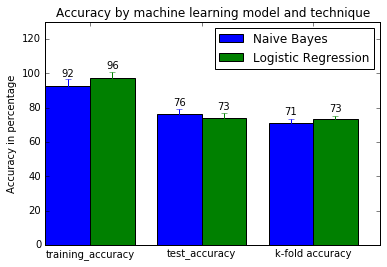

In [152]:
groups = 3

naive_bayes_means = (naive_bayes_training_data_accuracy * 100, naive_bayes_testing_data_accuracy * 100, 
                     naive_bayes_k_fold_accuracy * 100)

naive_bayes_std = (4, 3, 2)

logistic_regression_means = (logistic_regression_training_data_accuracy * 100, 
                             logistic_regression_testing_data_accuracy * 100, 
                             logistic_regression_k_fold_accuracy * 100)

logistic_regression_std = (4, 3, 2)

width = 0.40
ind_1 = np.arange(groups)
fig, ax = pyplot.subplots()
rects1 = ax.bar(ind_1, naive_bayes_means, width, color='b', yerr=naive_bayes_std)
rects2 = ax.bar(ind_1 + width, logistic_regression_means, width, color='g', yerr=logistic_regression_std)

ax.set_ylabel('Accuracy in percentage')
ax.set_title('Accuracy by machine learning model and technique')
ax.set_xticks(ind_1 + width)
ax.set_xticklabels(('training_accuracy', 'test_accuracy', 'k-fold accuracy'))
pyplot.ylim(ymax = 130, ymin = 0)

ax.legend((rects1[0], rects2[0]), ('Naive Bayes', 'Logistic Regression'))

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)


pyplot.figure(figsize=(15,5))

pyplot.show()

## Logistic Regression ROC Plotting

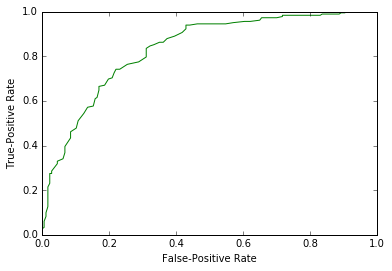

In [150]:
true_positive_list = []
false_positive_list = []
maximum_accuracy = -1
threshhold_value = 0
for i in range(0,200,1):
    logistic_regression_model.setThreshold(i/200)
    predictionLabelLogTest = test_data.map(lambda p: (float(logistic_regression_model.predict(p.features)), p.label))
    correct_results = 0
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    
    for single_item in predictionLabelLogTest.collect():
        if single_item[0] == single_item[1]:
            correct_results += 1
        
        if single_item[0] == 0 and single_item[1] == 0:
            true_negative += 1
        elif single_item[0] == 1 and single_item[1] == 0:
            false_positive += 1
        elif single_item[0] ==  1 and single_item[1] == 1:
            true_positive += 1
        else:
            false_negative += 1

    tpr = true_positive / (true_positive + false_negative)
    fpr = false_positive / (false_positive + true_negative)
    true_positive_list.append(tpr)
    false_positive_list.append(fpr)
    logistic_test_accuracy = correct_results/len(test_data.collect())
    if logistic_test_ac > maximum_accuracy:
        maximum_accuracy = logistic_test_accuracy
        threshhold_value = i/200
        precision = tpr
        recall = true_positive/true_positive + false_negative
        
pyplot.plot(false_positive_list, true_positive_list, color='g')
pyplot.xlabel("False-Positive Rate")
pyplot.ylabel("True-Positive Rate")
pyplot.show()

In [151]:
metricBinaryLog = BinaryClassificationMetrics(predictionLabelLogTest)
area_under_the_curve = metricBinaryLog.areaUnderROC
print("Area under the curve is")
print(area_under_the_curve)

Area under the curve is
0.5
